In [1]:
import scanpy as sc
import numpy as np
import cell2cell as c2c
import liana as li
import decoupler as dc
import pandas as pd
import plotnine as p9
from collections import defaultdict

/Users/pax/miniconda3/envs/liana-py/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pax/miniconda3/envs/liana-py/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pax/miniconda3/envs/liana-py/lib/python3.10/site-packages/uma

# Perform CCC analysis with Liana

In [ ]:
# The python script in this chunk was run in the cluster environment with 20 cores and 128GB memory.
import liana as li
import scanpy as sc
import muon as mu
import cell2cell as c2c
import decoupler as dc
from collections import defaultdict

adata = sc.read_h5ad('./results/02_mdata_mvi_Injury_state_edit.h5mu/rna')

adata.obs.Time = adata.obs.Time.astype('category')
adata.obs.Time = adata.obs.Time.cat.reorder_categories(adata.obs.Time.cat.categories)
adata.obs['Conditions_Time'] = adata.obs.Conditions.astype(str) + '&' + adata.obs.Time.astype(str)
adata = adata[adata.obs.NociceptiveType.isin(['SGC','Macrophage','B cell','Neutrophil','Nociceptors'])].copy()
adata.obs.NociceptiveType = adata.obs.NociceptiveType.astype(str)
adata.obs.NociceptiveType = adata.obs.NociceptiveType.astype('category')
adata.obs.scANVI_pred = adata.obs.scANVI_pred.astype(str)
adata.obs.scANVI_pred = adata.obs.scANVI_pred.astype('category')
adata.obs['Conditions_Time'] = adata.obs['Conditions_Time'].astype('category')
adata.obs['Conditions_Time'] = adata.obs['Conditions_Time'].cat.reorder_categories(['Naive&0day','CCI&14day','DRC&3day','SpNT&3day','Crush&3day','SpNT&0.25day','Crush&60day',
                                                                                    'ScNT&60day','ScNT&0.25day','ScNT&0.5day','ScNT&1day','ScNT&3day','ScNT&7day','ScNT&28day',
                                                                                    'Crush&0.25day','Crush&1day','Crush&7day','SpNT&0.5day','SpNT&1day','CFA&2day','Crush&14day',
                                                                                    'Crush&28day','Crush&90day','SpNT&1.5day','SpNT&2day','Paclitaxel&7day','SpNT&7day','ScNT&2day','ScNT&14day','CCI&7day','Sham&7day'])

li.mt.rank_aggregate.by_sample(
    adata,
    groupby='scANVI_pred',
    sample_key='Conditions_Time', # sample key by which we which to loop
    use_raw=False,
    verbose=True, # use 'full' to show all verbose information
    n_perms=1000, # reduce permutations for speed
    return_all_lrs=True, # return all LR values,
    resource_name='mouseconsensus'
    )

adata.write_h5ad('./results/adata_liana_scANVI_pred_Conditions_Time_Noci_immune.h5ad')

tensor = li.multi.to_tensor_c2c(adata,
                                sample_key='Conditions_Time',
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

adata.obs['PainState'] = 'Pain'
adata.obs.PainState[adata.obs.Time == '0day'] = 'NoPain'
context_dict = adata.obs[['Conditions_Time', 'Time']].drop_duplicates().sort_values('Time')
context_dict = dict(zip(context_dict['Conditions_Time'], context_dict['Time']))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=6, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )
c2c.io.export_variable_with_pickle(tensor, "./results/tensor_comp_scANVI_pred_Conditions_Time_Noci_immune.pkl")

In [2]:
tensor = c2c.io.load_tensor('results/tensor_comp_scANVI_pred_Conditions_Time_Noci_immune.pkl', device='mps')

In [3]:
adata = sc.read_h5ad('./results/adata_liana_scANVI_pred_Conditions_Time_Noci_immune.h5ad')

In [4]:
adata.uns["liana_res"]

,Conditions_Time,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
0,Naive&0day,Neutrophil,Macrophage,S100a9,Cd68,258.822968,0.0,891.096985,3.266157,NaN,0.898847,0.984914,0.000028,0.0,NaN,7.616211e-13
1,Naive&0day,Neutrophil,Macrophage,S100a8,Cd68,222.096619,0.0,764.229248,3.274880,NaN,0.898266,0.983730,0.000024,0.0,NaN,1.209421e-12
2,Naive&0day,SGC,cLTMR1,Apoe,Sorl1,174.798660,0.0,801.564697,0.901529,NaN,0.148968,0.984107,0.000029,0.0,NaN,4.195750e-12
3,Naive&0day,SGC,NP,Apoe,Ldlr,174.781296,0.0,789.507202,0.807841,NaN,0.130039,0.983988,0.000029,0.0,NaN,5.447201e-12
4,Naive&0day,SGC,PEP1,Apoe,Ldlr,174.690460,0.0,726.413757,0.766903,NaN,0.119647,0.983319,0.000020,0.0,NaN,6.925607e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8457390,Sham&7day,p_cLTMR2,p_cLTMR2,Fstl5,Sdk2,0.107504,1.0,0.011544,-1.373875,-inf,0.000053,0.049185,0.000000,1.0,NaN,1.000000e+00
8457391,Sham&7day,p_cLTMR2,p_cLTMR2,Tph1,Htr5a,0.107504,1.0,0.011544,-1.373875,-inf,0.000053,0.049185,0.000000,1.0,NaN,1.000000e+00
8457392,Sham&7day,p_cLTMR2,p_cLTMR2,Gnai2,Adra2b,0.107504,1.0,0.011544,-1.373875,-inf,0.000053,0.049185,0.000000,1.0,NaN,1.000000e+00
8457393,Sham&7day,p_cLTMR2,p_cLTMR2,Tph1,Htr4,0.107504,1.0,0.011544,-1.373875,-inf,0.000053,0.049185,0.000000,1.0,NaN,1.000000e+00


In [6]:
adata.obs['PainState'] = 'Pain'
adata.obs.PainState[adata.obs.Time == '0day'] = 'NoPain'

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16922/2340304970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
adata.uns["liana_res"][['Conditions','Time']] = adata.uns["liana_res"].Conditions_Time.str.split('&', expand=True)
adata.uns["liana_res"].to_csv('./liana_CCC_Conditions_Time_Noci_immune.csv')

In [14]:
# adata.uns["liana_res"].to_csv('./liana_CCC_Conditions_Time_Noci_immune.csv')

In [8]:
df = adata.uns["liana_res"].copy()
df['source_Noci'] = df.source.replace(['NP','PEP1','PEP2','SST','cLTMR1','p_cLTMR2'], 'Nociceptors')
df['target_Noci'] = df.target.replace(['NP','PEP1','PEP2','SST','cLTMR1','p_cLTMR2'], 'Nociceptors')

In [9]:
context_dict = adata.obs[['Conditions_Time','PainState']].drop_duplicates().sort_values('PainState')
context_dict = dict(zip(context_dict['Conditions_Time'], context_dict['PainState']))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

In [10]:
# tensor_meta[0].Category = tensor_meta[0].Category.astype('category').cat.reorder_categories(adata.obs.Time.cat.categories)
tensor_meta[0] = tensor_meta[0].sort_values('Category')

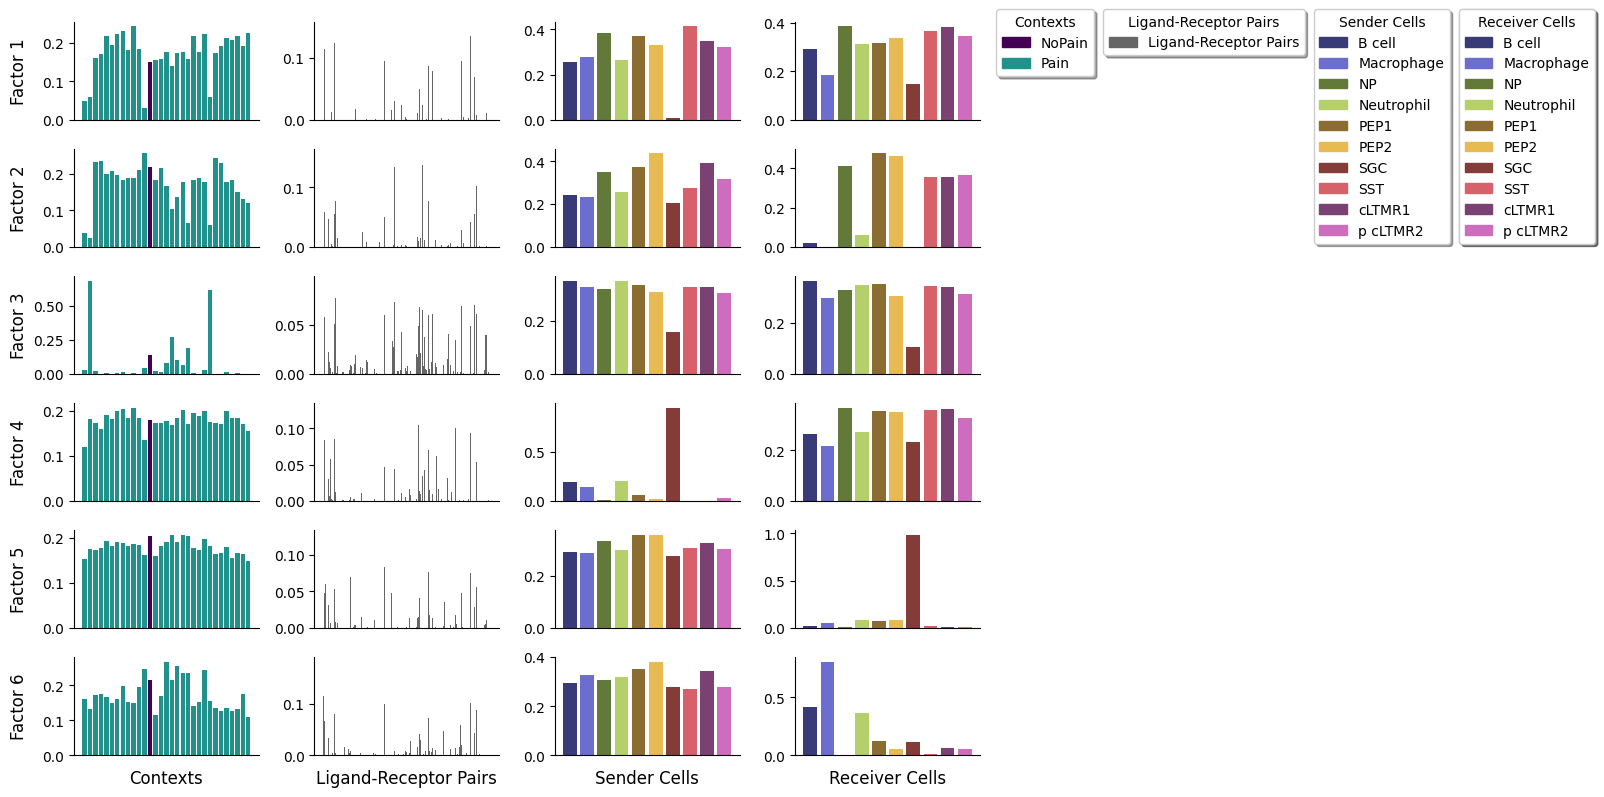

In [11]:
fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['viridis', 'Dark2_r', 'tab20b', 'tab20b'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )

In [12]:
fig.savefig('/Users/pax/Manu_fig/eps/Tensor_decomp.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
factors = tensor.factors

In [14]:
lr_loadings = factors['Ligand-Receptor Pairs']
lr_loadings.sort_values("Factor 3", ascending=False).head(10)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
Fam3c^Lifr,1.373461e-02,0.033298,0.094635,2.210978e-02,2.175637e-02,4.677213e-02
Rims2^Abca1,4.012978e-06,0.000179,0.091049,3.042222e-07,1.588612e-02,1.667904e-02
Vegfb^Ret,1.761876e-03,0.059876,0.089610,5.501563e-03,1.807288e-02,6.323759e-02
App^Ncstn,5.246711e-03,0.055495,0.088000,1.918013e-02,3.676547e-02,6.830267e-02
Tgfb1^Itgb1,1.757113e-02,0.002514,0.082296,1.295909e-02,1.934862e-02,3.087633e-02
Psap^Ar,3.113248e-03,0.127963,0.081690,2.807320e-02,8.364786e-08,3.642474e-02
Hras^Insr,1.700964e-04,0.068870,0.081090,3.691302e-03,7.158161e-03,4.730203e-05
Ptn^Ptprs,4.385395e-03,0.070643,0.080996,9.007276e-02,5.203062e-02,7.372334e-02
Slc6a8^Lifr,1.099268e-07,0.016013,0.080431,3.211261e-02,9.315195e-03,6.386024e-08
Ptn^Sdc3,9.294993e-03,0.046664,0.079270,8.152731e-02,5.638117e-02,7.382205e-02


In [15]:
net = dc.get_progeny(organism='mouse', top=3000)

In [16]:
net

,source,target,weight,p_value
0,Androgen,Tmprss2,11.490631,0.000000e+00
1,EGFR,Tmprss2,-0.684105,1.210350e-04
2,Estrogen,Tmprss2,-2.381094,9.506935e-03
3,MAPK,Tmprss2,-0.714285,6.069887e-08
4,WNT,Tmprss2,-1.012412,3.382022e-01
...,...,...,...,...
38067,p53,Trim58,-1.210856,7.199435e-03
38068,p53,Jph1,-2.095344,7.403845e-03
38069,p53,Vtn,1.695722,7.431462e-03
38070,p53,Ncoa6,-0.893406,7.550385e-03


In [17]:
lr_pairs = li.rs.select_resource('mouseconsensus')

In [18]:
lr_pairs

,ligand,receptor
31449,Dll1,Notch1
31450,Dll1,Notch2
31451,Dll1,Notch4
31452,Dll1,Notch3
31453,Nrg2,Erbb2_Erbb3
...,...,...
35442,Serpina1a,Lrp1
35443,Serpina1b,Lrp1
35444,Serpina1c,Lrp1
35445,Serpina1d,Lrp1


In [19]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_separator="^")
lr_progeny.head()

,source,interaction,weight
19,WNT,Adam17^Notch1,-0.951469
33,WNT,Dll3^Notch1,-0.626443
43,WNT,Rbp3^Notch1,-0.541157
107,TGFb,Jag1^Notch2,1.625120
238,NFkB,Psen1^Notch4,0.801845


In [20]:
# run enrichment analysis
estimate, pvals = dc.run_mlm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

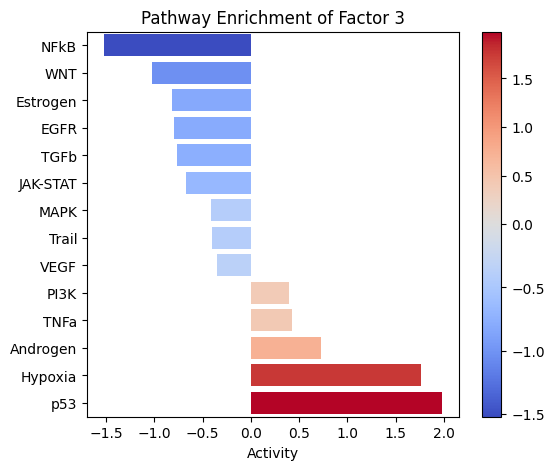

In [21]:
fig = dc.plot_barplot(estimate, 'Factor 3', vertical=True, cmap='coolwarm', figsize=(6,5), dpi=100, return_fig=True,)
fig.axes[0].set_title('Pathway Enrichment of Factor 3')
fig.savefig('/Users/pax/Manu_fig/eps/f3_pathway.eps', bbox_inches='tight', dpi=300)

# Prepare data and plot chord diagram

In [ ]:
liana_res = adata.uns['liana_res'].copy()
liana_res_filt = liana_res[(liana_res.cellphone_pvals < 0.01) & (liana_res.cellchat_pvals < 0.01) & (liana_res.lr_means > 1)]
liana_res_filt.Time = liana_res_filt.Time.astype('category')
liana_res_filt.Time = liana_res_filt.Time.cat.reorder_categories(adata.obs.Time.cat.categories)

In [ ]:
group_df = liana_res_filt.groupby(['Time','source']).target.value_counts().to_frame()
group_df.rename(columns={'target':'count'}, inplace=True)
group_df = group_df.reset_index()
group_df.Time = group_df.Time.cat.reorder_categories(adata.obs.Time.cat.categories)
group_df = group_df[['source','target','Time','count']] # different order from sankey plot
group_df = group_df[group_df['count']>1]
group_df.to_csv('CCC_scANVI_pred.csv')

## Plot chord diagram in R

In [ ]:
#!/usr/bin/Rscript

# expecting that the libraries below are installed
# library(circlize)
# library(dplyr)
# library(RColorBrewer)

# df <- read.csv("./liana_CCC_Conditions_Time_Noci_immune.csv", row.names=1)
# df <- df %>% filter(!(Time %in% c('60day','90day')))

# all_times <- unique(df[[3]])
# color_times <- structure(brewer.pal(length(all_times), "Set3"), names = all_times)

# all_ct <- unique(df[[1]])
# color_ct <- structure(brewer.pal(length(all_ct), "Paired"), names = all_ct)

# df2 <- data.frame(from = paste(df[[1]], df[[3]], sep = "|"),
#                  to = paste(df[[2]], df[[3]], sep = "|"),
#                  value = df[[4]], stringsAsFactors = FALSE)

# # df$Time <- factor(df$Time, levels=c('0day','0.25day','0.5day','1day','1.5day','2day','3day','7day','14day','28day','60day','90day'))
# df$Time <- factor(df$Time, levels=c('0day','0.25day','0.5day',
#                                     '1day','1.5day','2day',
#                                     '3day','7day','14day','28day'))
# df <- df[order(df$Time,decreasing=FALSE),]
# # df$Time <- as.character(df$Time)
# combined <- unique(data.frame(ct = c(df[[1]], df[[2]]), Time = c(df[[3]], df[[3]]), stringsAsFactors = FALSE))
# combined <- combined[order(combined$ct, combined$Time), ]
# order <- paste(combined$ct, combined$Time, sep = "|")
# grid.col <- structure(color_times[combined$Time], names = order)

# gap <- rep(1, length(order))
# gap[which(!duplicated(combined$Time, fromLast = TRUE))] = 5


# pdf('./Chord_diagram.pdf', width = 9.5)
# circos.par(gap.degree = gap)
# chordDiagram(df2, order = order, annotationTrack = c("grid", "axis"),
#     grid.col = grid.col, directional = TRUE, direction.type="diffHeight",
#     preAllocateTracks = list(
#         track.height = 0.04,
#         track.margin = c(0.05, 0)
#     )
# )
# for(region in unique(combined$ct)) {
#     l <- combined$ct == region
#     sn <- paste(combined$ct[l], combined$Time[l], sep = "|")
#     highlight.sector(sn, track.index = 1, col = color_ct[region],
#                      text = region, niceFacing = TRUE, text.vjust='4mm')
# }
# circos.clear()

# legend(x=1.1,y=1, pch = 15, col = color_ct,legend = names(color_ct), cex = 0.8)
# legend(x=1.1,y=-0.1, pch = 15, col = color_times, legend = names(color_times), cex = 0.8)
# dev.off()
